# Training RNN for Time Series

### Import libraries

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Reading and Checking out dataset 

You can find more information about the dataset on the following link: https://fred.stlouisfed.org/series/TRFVOLUSM227NFWA


In [5]:
df = pd.read_csv('Miles_Traveled.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'

In [6]:
df.head()

,TRFVOLUSM227NFWA
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0


**Change the column name to Mileage**

In [8]:
df.columns = ['Mileage']

**EDA**

**Let's first plot the TimeSeries**

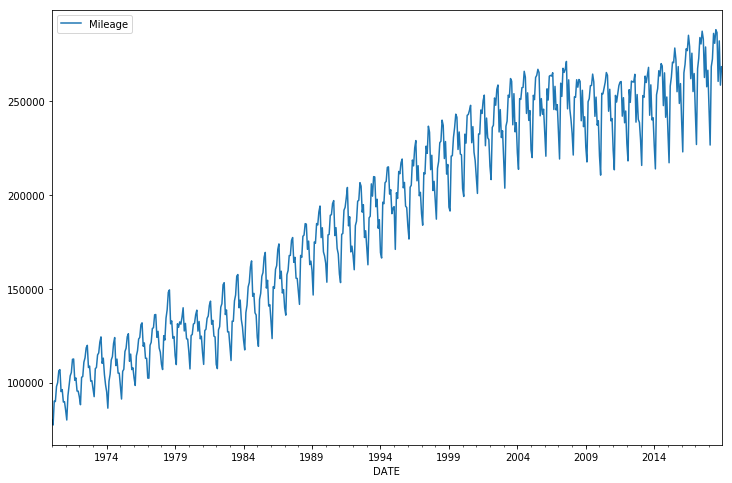

In [9]:
df.plot(figsize=(12,8))

** We Perform a Seasonal Decomposition on the model and plot out the ETS components**

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

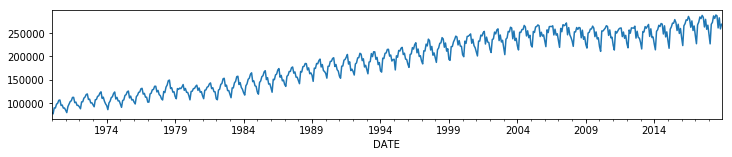

In [11]:
results = seasonal_decompose(df['Mileage'])
results.observed.plot(figsize=(12,2))

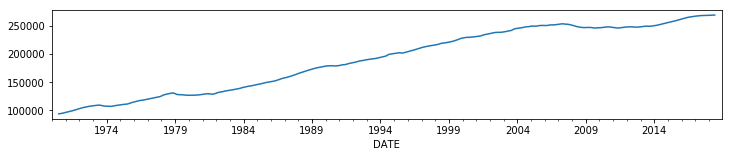

In [16]:
results.trend.plot(figsize=(12,2))
plt.show()

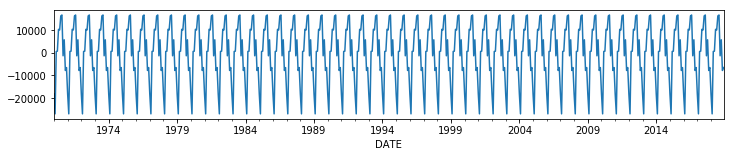

In [15]:
results.seasonal.plot(figsize=(12,2))
plt.show()

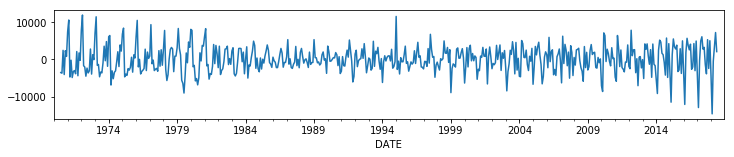

In [17]:
results.resid.plot(figsize=(12,2))
plt.show()

## Now we split dataset into Train and Test sets

First, we need to figure out the length of the TimeSeries

In [18]:
len(df)

588

In [20]:
# 12 Months
train_len = len(df)-12

The test set is the last 12 months of data and the rest is training set.

In [21]:
train = df.iloc[:train_len]
test = df.iloc[train_len:]

In [23]:
len(test) # Checking the length of training set 

12

## Scaling the dataset

**Using a MinMaxScaler to scale the train and test sets into scaled versions.**

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
scaler = MinMaxScaler()

In [26]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [27]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Generating Time Series

**We create a TimeSeriesGenerator object using the scaled training data. The minimum input is 12**

In [28]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [29]:
n_input = 24
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

### Model Creation

**TASK: Create a Keras Sequential Model with LSTAM units and a final Dense Layer.**

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [31]:
# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


**Fitting the model to the generator**

In [33]:
# fit model
model.fit_generator(generator,epochs=30) # To get a better model we should train the model for higher epochs


Epoch 1/30
552/552 [==============================] - 48s 87ms/step - loss: 0.0133
Epoch 2/30
552/552 [==============================] - 46s 83ms/step - loss: 0.0061
Epoch 3/30
552/552 [==============================] - 46s 84ms/step - loss: 0.0058
Epoch 4/30
552/552 [==============================] - 45s 82ms/step - loss: 0.0058
Epoch 5/30
552/552 [==============================] - 45s 81ms/step - loss: 0.0053
Epoch 6/30
552/552 [==============================] - 45s 81ms/step - loss: 0.0044
Epoch 7/30
552/552 [==============================] - 49s 88ms/step - loss: 0.0030
Epoch 8/30
552/552 [==============================] - 56s 102ms/step - loss: 0.0022
Epoch 9/30
552/552 [==============================] - 45s 81ms/step - loss: 0.0023
Epoch 10/30
552/552 [==============================] - 44s 79ms/step - loss: 0.0022
Epoch 11/30
552/552 [==============================] - 44s 79ms/step - loss: 0.0018
Epoch 12/30
552/552 [==============================] - 44s 80ms/step - loss: 0.0021

**Plotting loss per epoch**

In [35]:
model.history.history.keys()

dict_keys(['loss'])

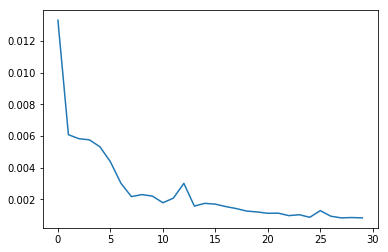

In [36]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Evaluation of the model using test dataset

**Based on the test data and input size, we create an appropriately sized "first evaluation batch"**

In [37]:
first_eval_batch = scaled_train[-12:]

In [38]:
first_eval_batch

array([[0.79630397],
       [0.71226435],
       [0.90477416],
       [0.93121043],
       [0.98386382],
       [0.96757519],
       [1.        ],
       [0.9801859 ],
       [0.8824684 ],
       [0.95995255],
       [0.85883345],
       [0.90086755]])

In [39]:
first_eval_batch = first_eval_batch.reshape((1, 12, n_features))

**Now, we generate predictions into the same time stamps as the test set**

In [40]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Inverse Transformations and Compare

**We Inverse Transform our new forecasted predictions and compare with the test set.**

In [41]:
true_predictions = scaler.inverse_transform(test_predictions)

In [42]:
true_predictions

array([[251756.42450345],
       [239585.11321181],
       [273752.45743436],
       [279276.70988774],
       [288295.64326   ],
       [288955.15204346],
       [294242.68245542],
       [290141.45213163],
       [277813.78994143],
       [284344.98371834],
       [269227.66468191],
       [273227.14243644]])

**For the sake of comparison we create a new dataframe that has both the original test values and your predictions for them.**

In [43]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [44]:
test

,Mileage,Predictions
DATE,,
2018-01-01,245695.0,251756.424503
2018-02-01,226660.0,239585.113212
2018-03-01,268480.0,273752.457434
2018-04-01,272475.0,279276.709888
2018-05-01,286164.0,288295.643260
2018-06-01,280877.0,288955.152043
2018-07-01,288145.0,294242.682455
2018-08-01,286608.0,290141.452132
2018-09-01,260595.0,277813.789941


**Now we can compare the predicted values by plotting out the test set vs. model's predicted values.**

In [ ]:
test.plot(figsize=(12,8))

In [34]:
# Note that for getting better results we can fine tune the hyperparameters to get higher accuracy.

# Saving Models

**We save the model to retrain it at later time**

In [44]:
model.save('solutions_model.h5')